<a href="https://colab.research.google.com/github/LelyshB/parsing_and_clearing_Wildberiess/blob/main/parsing_and_clearing_Wildberiess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Парсим данные с wildberries**


In [1]:
import datetime
import requests
import pandas as pd
from retry import retry


HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/113.0",
    "Accept": "*/*",
    "Accept-Language": "ru-RU,ru;q=0.8,en-US;q=0.5,en;q=0.3",
    "Accept-Encoding": "gzip, deflate, br",
    "Origin": "https://www.wildberries.ru",
    'Content-Type': 'application/json; charset=utf-8',
    'Transfer-Encoding': 'chunked',
    "Connection": "keep-alive",
    'Vary': 'Accept-Encoding',
    'Content-Encoding': 'gzip',
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "cross-site"
}
CATALOG_URL = 'https://static-basket-01.wbbasket.ru/vol0/data/main-menu-ru-ru-v2.json'


def get_catalogs_wb() -> dict:
    """получаем полный каталог Wildberries"""
    return requests.get(CATALOG_URL, headers=HEADERS).json()


def get_data_category(catalogs_wb: dict) -> list:
    """сбор данных категорий из каталога Wildberries"""
    catalog_data = []
    if isinstance(catalogs_wb, dict) and 'childs' not in catalogs_wb:
        catalog_data.append({
            'name': f"{catalogs_wb['name']}",
            'shard': catalogs_wb.get('shard', None),
            'url': catalogs_wb['url'],
            'query': catalogs_wb.get('query', None)
        })
    elif isinstance(catalogs_wb, dict):
        catalog_data.extend(get_data_category(catalogs_wb['childs']))
    else:
        for child in catalogs_wb:
            catalog_data.extend(get_data_category(child))
    return catalog_data


def search_category_in_catalog(url: str, catalog_list: list) -> dict:
    """проверка пользовательской ссылки на наличии в каталоге"""
    for catalog in catalog_list:
        if catalog['url'] == url.split('https://www.wildberries.ru')[-1]:
            print(f'найдено совпадение: {catalog["name"]}')
            return catalog


def get_data_from_json(json_file: dict) -> list:
    """извлекаем из json данные"""
    data_list = []
    for data in json_file['data']['products']:
        data_list.append({
            'id': data.get('id'),
            'Наименование': data.get('name'),
            'Цена': int(data.get("priceU") / 100),
            'Цена со скидкой': int(data.get('salePriceU') / 100),
            'Скидка': data.get('sale'),
            'Бренд': data.get('brand'),
            'Рейтинг': data.get('rating'),
            'Продавец': data.get('supplier'),
            'Рейтинг продавца': data.get('supplierRating'),
            'Кол-во отзывов': data.get('feedbacks'),
            'Рейтинг отзывов': data.get('reviewRating'),
            'Промо текст карточки': data.get('promoTextCard'),
            'Промо текст категории': data.get('promoTextCat'),
            'Ссылка': f'https://www.wildberries.ru/catalog/{data.get("id")}/detail.aspx?targetUrl=BP'
        })
    return data_list


@retry(Exception, tries=-1, delay=0)
def scrap_page(page: int, shard: str, query: str, low_price: int, top_price: int, discount: int = None) -> dict:
    """Сбор данных со страниц"""
    url = f'https://catalog.wb.ru/catalog/{shard}/catalog?appType=1&curr=rub' \
          f'&dest=-1257786' \
          f'&locale=ru' \
          f'&page={page}' \
          f'&priceU={low_price * 100};{top_price * 100}' \
          f'&sort=popular&spp=0' \
          f'&{query}' \
          f'&discount={discount}'

    r = requests.get(url, headers=HEADERS)
    return r.json()


def save_csv(data: list, filename: str):
    """сохранение результата в CSV файл"""
    df = pd.DataFrame(data)
    df.to_csv(f'{filename}.csv', index=False)
    print(f'Все сохранено в {filename}.csv\n')


def parser(url: str, low_price: int = 1, top_price: int = 1000000, discount: int = 0):
    """основная функция"""
    # получаем данные по заданному каталогу
    catalog_data = get_data_category(get_catalogs_wb())

    # поиск введенной категории в общем каталоге
    category = search_category_in_catalog(url=url, catalog_list=catalog_data)
    data_list = []
    for page in range(1, 51):  # вб отдает 50 страниц товара
        data = scrap_page(
            page=page,
            shard=category['shard'],
            query=category['query'],
            low_price=low_price,
            top_price=top_price,
            discount=discount)
        if len(get_data_from_json(data)) > 0:
            data_list.extend(get_data_from_json(data))
        else:
            break
    print(f'Сбор данных завершен. Собрано: {len(data_list)} товаров.')

    # сохранение найденных данных
    save_csv(data_list, f'{category["name"]}_from_{low_price}_to_{top_price}')

if __name__ == '__main__':
    url = 'https://www.wildberries.ru/catalog/elektronika/smartfony-i-telefony/vse-smartfony'
    low_price = 100  # нижний порог цены
    top_price = 100000  # верхний порог цены
    discount = 10  # скидка в %
    start = datetime.datetime.now()  # запишем время старта

    parser(url=url, low_price=low_price, top_price=top_price, discount=discount)

    end = datetime.datetime.now()  # запишем время завершения кода
    total = end - start  # расчитаем время затраченное на выполнение кода
    print("Затраченное время:" + str(total))

найдено совпадение: Смартфоны


Сбор данных завершен. Собрано: 5000 товаров.
Все сохранено в Смартфоны_from_100_to_100000.csv

Затраченное время:0:00:44.028848



# **Приступаем к анализу данных**

In [50]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing


plt.style.use('dark_background')

In [62]:
df = pd.read_csv('/content/Смартфоны_from_100_to_100000.csv')

In [63]:
df.sample(5)

,id,Наименование,Цена,Цена со скидкой,Скидка,Бренд,Рейтинг,Продавец,Рейтинг продавца,Кол-во отзывов,Рейтинг отзывов,Промо текст карточки,Промо текст категории,Ссылка
3932,189369849,Pova Neo 3 4+128 GB,12380,9136,26,TECNO,5,Интернет Фаворит,4.7,30,4.8,NaN,NaN,https://www.wildberries.ru/catalog/189369849/d...
1368,182171040,Смартфон Y36 4 128 ГБ,15289,12160,20,Vivo,0,TEHNO STORE,4.8,0,0.0,NaN,NaN,https://www.wildberries.ru/catalog/182171040/d...
753,207783435,Смартфон Hot 40 X6836 8 256 ГБ черный,17830,11988,32,Infinix,5,ЗЕОН,4.8,129,4.6,КЛИЕНТСКИЕ ДНИ,КЛИЕНТСКИЕ ДНИ,https://www.wildberries.ru/catalog/207783435/d...
2070,212595500,Смартфон red note 7 pro 6 128 гб,12500,7790,37,MI,5,profitzone,4.2,3,4.7,КЛИЕНТСКИЕ ДНИ,КЛИЕНТСКИЕ ДНИ,https://www.wildberries.ru/catalog/212595500/d...
781,218495153,"Смартфон Y27s 8+256 ГБ, черный бургунди",17645,12298,30,VIVO,0,vivo,4.5,0,0.0,NaN,NaN,https://www.wildberries.ru/catalog/218495153/d...


In [64]:
df.isna().sum()

id                          0
Наименование                0
Цена                        0
Цена со скидкой             0
Скидка                      0
Бренд                      42
Рейтинг                     0
Продавец                    0
Рейтинг продавца            0
Кол-во отзывов              0
Рейтинг отзывов             0
Промо текст карточки     2543
Промо текст категории    2543
Ссылка                      0
dtype: int64

In [65]:
df.describe()

,id,Цена,Цена со скидкой,Скидка,Рейтинг,Рейтинг продавца,Кол-во отзывов,Рейтинг отзывов
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.966564e+08,30505.684800,20288.068800,31.276600,2.763000,4.571260,97.275600,2.714640
std,2.342863e+07,28772.450547,19169.537636,14.268511,2.315406,0.280178,664.935864,2.272794
min,2.720788e+07,350.000000,140.000000,0.000000,0.000000,3.600000,0.000000,0.000000
25%,1.883867e+08,12990.000000,8854.500000,18.000000,0.000000,4.400000,0.000000,0.000000
50%,2.062721e+08,20000.000000,13334.000000,29.000000,4.000000,4.600000,2.000000,4.000000
75%,2.110261e+08,36409.000000,23356.000000,39.000000,5.000000,4.800000,21.000000,4.900000
max,2.203053e+08,470000.000000,103521.000000,95.000000,5.000000,5.000000,12915.000000,5.000000


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     5000 non-null   int64  
 1   Наименование           5000 non-null   object 
 2   Цена                   5000 non-null   int64  
 3   Цена со скидкой        5000 non-null   int64  
 4   Скидка                 5000 non-null   int64  
 5   Бренд                  4958 non-null   object 
 6   Рейтинг                5000 non-null   int64  
 7   Продавец               5000 non-null   object 
 8   Рейтинг продавца       5000 non-null   float64
 9   Кол-во отзывов         5000 non-null   int64  
 10  Рейтинг отзывов        5000 non-null   float64
 11  Промо текст карточки   2457 non-null   object 
 12  Промо текст категории  2457 non-null   object 
 13  Ссылка                 5000 non-null   object 
dtypes: float64(2), int64(6), object(6)
memory usage: 547.0+ 

In [ ]:
df = df.drop(['id', 'Ссылка'], axis = 1)


In [ ]:
df.sample(5)

,id,Наименование,Цена,Цена со скидкой,Скидка,Бренд,Рейтинг,Продавец,Рейтинг продавца,Кол-во отзывов,Рейтинг отзывов,Промо текст карточки,Промо текст категории,Ссылка
3932,189369849,Pova Neo 3 4+128 GB,12380,9136,26,TECNO,5,Интернет Фаворит,4.7,30,4.8,NaN,NaN,https://www.wildberries.ru/catalog/189369849/d...
1368,182171040,Смартфон Y36 4 128 ГБ,15289,12160,20,Vivo,0,TEHNO STORE,4.8,0,0.0,NaN,NaN,https://www.wildberries.ru/catalog/182171040/d...
753,207783435,Смартфон Hot 40 X6836 8 256 ГБ черный,17830,11988,32,Infinix,5,ЗЕОН,4.8,129,4.6,КЛИЕНТСКИЕ ДНИ,КЛИЕНТСКИЕ ДНИ,https://www.wildberries.ru/catalog/207783435/d...
2070,212595500,Смартфон red note 7 pro 6 128 гб,12500,7790,37,MI,5,profitzone,4.2,3,4.7,КЛИЕНТСКИЕ ДНИ,КЛИЕНТСКИЕ ДНИ,https://www.wildberries.ru/catalog/212595500/d...
781,218495153,"Смартфон Y27s 8+256 ГБ, черный бургунди",17645,12298,30,VIVO,0,vivo,4.5,0,0.0,NaN,NaN,https://www.wildberries.ru/catalog/218495153/d...


In [ ]:
df.sample(5)

,id,Наименование,Цена,Цена со скидкой,Скидка,Бренд,Рейтинг,Продавец,Рейтинг продавца,Кол-во отзывов,Рейтинг отзывов,Промо текст карточки,Промо текст категории,Ссылка
3932,189369849,Pova Neo 3 4+128 GB,12380,9136,26,TECNO,5,Интернет Фаворит,4.7,30,4.8,NaN,NaN,https://www.wildberries.ru/catalog/189369849/d...
1368,182171040,Смартфон Y36 4 128 ГБ,15289,12160,20,Vivo,0,TEHNO STORE,4.8,0,0.0,NaN,NaN,https://www.wildberries.ru/catalog/182171040/d...
753,207783435,Смартфон Hot 40 X6836 8 256 ГБ черный,17830,11988,32,Infinix,5,ЗЕОН,4.8,129,4.6,КЛИЕНТСКИЕ ДНИ,КЛИЕНТСКИЕ ДНИ,https://www.wildberries.ru/catalog/207783435/d...
2070,212595500,Смартфон red note 7 pro 6 128 гб,12500,7790,37,MI,5,profitzone,4.2,3,4.7,КЛИЕНТСКИЕ ДНИ,КЛИЕНТСКИЕ ДНИ,https://www.wildberries.ru/catalog/212595500/d...
781,218495153,"Смартфон Y27s 8+256 ГБ, черный бургунди",17645,12298,30,VIVO,0,vivo,4.5,0,0.0,NaN,NaN,https://www.wildberries.ru/catalog/218495153/d...


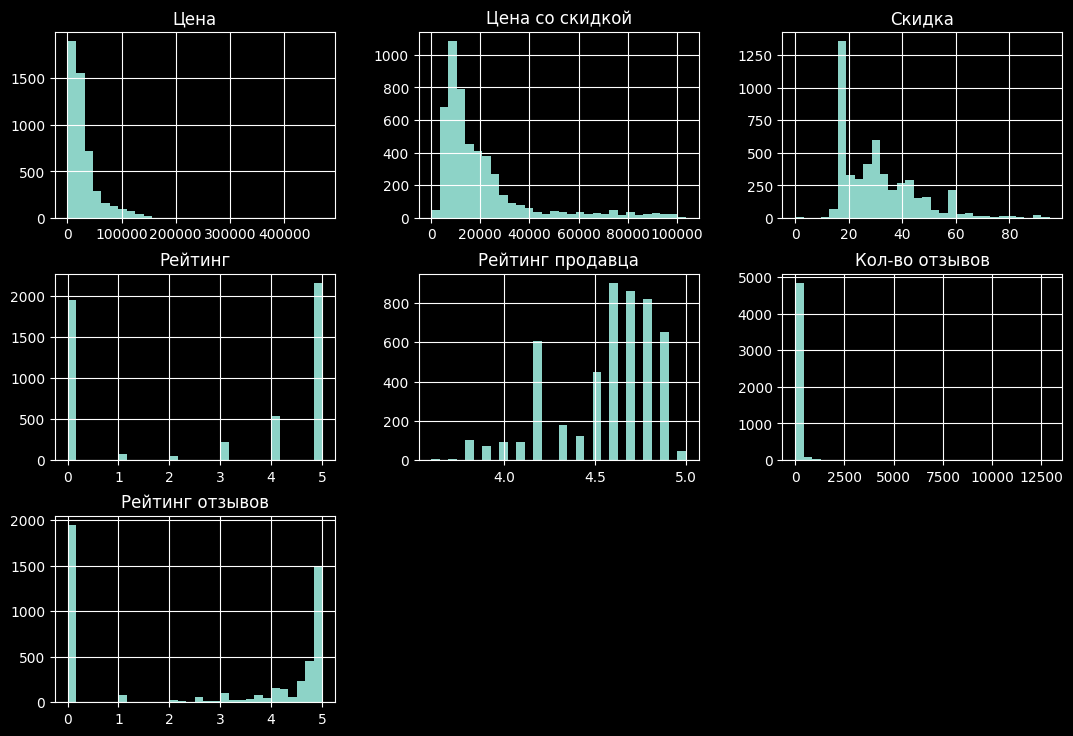

In [68]:
df.hist(bins=30, figsize=(13, 15), layout=(5, 3))
plt.show()

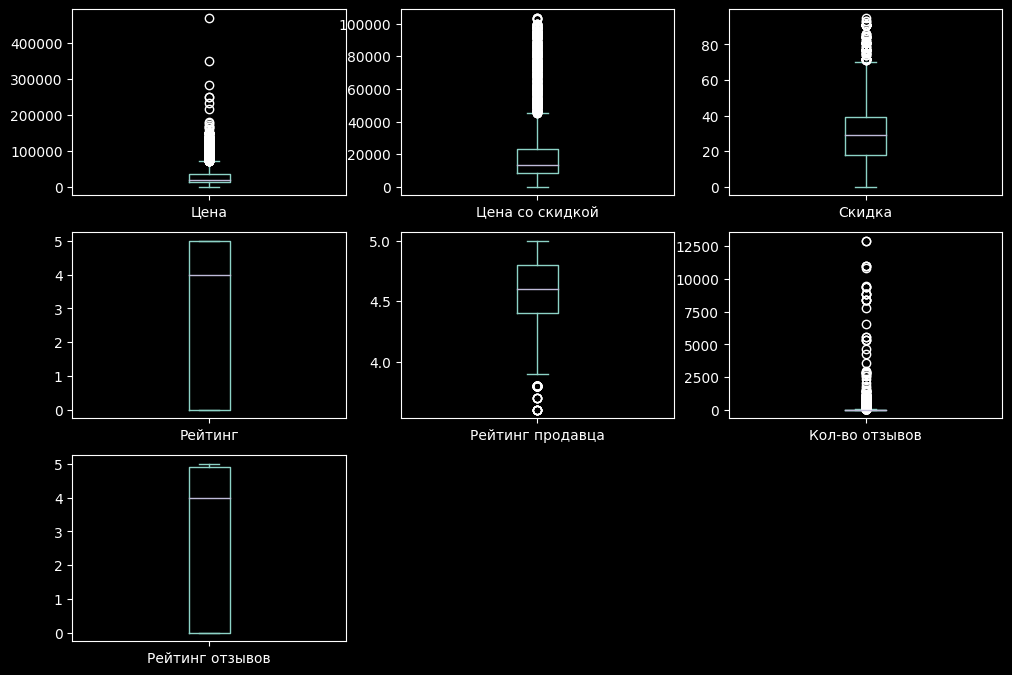

In [69]:
df.plot(kind='box', subplots=True, layout=(5, 3), figsize=(12, 14))
plt.show()

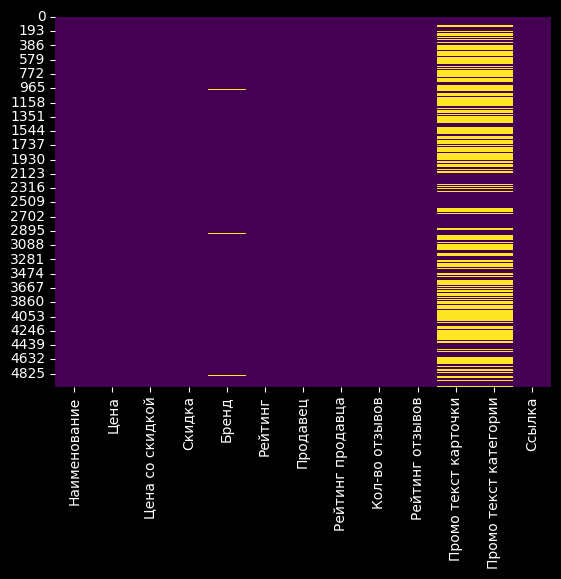

In [70]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

**Из анализа можно понять:**

 * В некоторых переменных присутствуют широкие хвосты

 * У двух переменных отсутствует слишком много значений, поэтому избавляемся от них

Также уберём нули в колонке "Бренд"

In [71]:
df =  df.drop(['Промо текст карточки', 'Промо текст категории'], axis = 1)

In [72]:
df['Бренд']  = df['Бренд'].fillna('nan')

In [73]:
df.isna().sum()

Наименование        0
Цена                0
Цена со скидкой     0
Скидка              0
Бренд               0
Рейтинг             0
Продавец            0
Рейтинг продавца    0
Кол-во отзывов      0
Рейтинг отзывов     0
Ссылка              0
dtype: int64

Далее нормализуем данные. Это может быть полезно в дальнейшем

In [74]:
scaler = preprocessing.MinMaxScaler()

numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [75]:
df.describe()

,Цена,Цена со скидкой,Скидка,Рейтинг,Рейтинг продавца,Кол-во отзывов,Рейтинг отзывов
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.064209,0.194891,0.329227,0.552600,0.693757,0.007532,0.542928
std,0.061264,0.185426,0.150195,0.463081,0.200127,0.051486,0.454559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.026914,0.084295,0.189474,0.000000,0.571429,0.000000,0.000000
50%,0.041840,0.127625,0.305263,0.800000,0.714286,0.000155,0.800000
75%,0.076778,0.224567,0.410526,1.000000,0.857143,0.001626,0.980000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


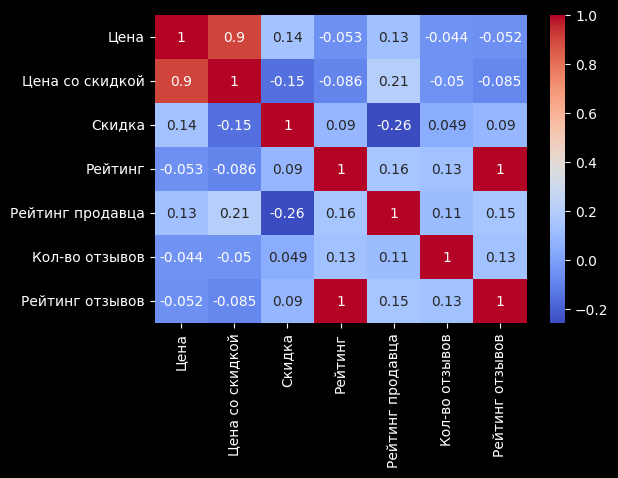

In [80]:
corr_matrix = df[numerical_columns].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [82]:
df

,Наименование,Цена,Цена со скидкой,Скидка,Бренд,Рейтинг,Продавец,Рейтинг продавца,Кол-во отзывов,Рейтинг отзывов,Ссылка
0,C65 8GB+256GB,0.033301,0.099177,0.368421,POCO,1.0,Wildberries,0.785714,0.048161,0.96,https://www.wildberries.ru/catalog/192893332/d...
1,Redmi 12C 4GB+128GB,0.023720,0.075333,0.326316,Xiaomi,1.0,Wildberries,0.785714,0.020828,0.98,https://www.wildberries.ru/catalog/150620927/d...
2,Redmi 12C 4GB+128GB,0.023720,0.075333,0.326316,Xiaomi,1.0,Wildberries,0.785714,0.020828,0.98,https://www.wildberries.ru/catalog/150620930/d...
3,Note 50 3+64GB,0.015222,0.045627,0.368421,Realme,1.0,WB Retail,0.928571,0.079365,0.96,https://www.wildberries.ru/catalog/201824181/d...
4,Смартфон M6 Pro Purple 12GB RAM 512GB ROM,0.069007,0.206508,0.357895,POCO,1.0,diMoll,0.785714,0.000542,1.00,https://www.wildberries.ru/catalog/200560435/d...
...,...,...,...,...,...,...,...,...,...,...,...
4995,Смартфон Galaxy A05 4 128Gb,0.032188,0.104149,0.305263,Samsung,0.0,Официальный магазин BrandBooster,0.785714,0.000000,0.00,https://www.wildberries.ru/catalog/193984874/d...
4996,Смартфон Tecnо SPARK 20C 4 256 Gb,0.025423,0.096120,0.189474,TECNO,1.0,Официальный магазин,0.785714,0.000232,1.00,https://www.wildberries.ru/catalog/212060272/d...
4997,Смартфон SPARK GO 2024 64Gb,0.014690,0.056142,0.189474,Tecno,1.0,Lavanda,0.785714,0.000077,1.00,https://www.wildberries.ru/catalog/212512806/d...
4998,Смартфон iPhone 12 mini 256 ГБ черный Восстано...,0.106794,0.279065,0.442105,Apple,1.0,Надежные смартфоны,0.500000,0.003252,0.98,https://www.wildberries.ru/catalog/180892454/d...
